## Análisis del dataset limpio

In [1]:
# Importo las liberias básicas.
import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# Leo el dataset en un dataframe.
data = pd.read_csv("../data/CleanProperati.csv")

# Veo la info general del dataframe.
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 119899 entries, 0 to 119898
Data columns (total 30 columns):
 #   Column                      Non-Null Count   Dtype  
---  ------                      --------------   -----  
 0   Unnamed: 0.1                119899 non-null  int64  
 1   Unnamed: 0                  119899 non-null  int64  
 2   geonames_id                 101511 non-null  float64
 3   lat                         68728 non-null   float64
 4   lon                         68728 non-null   float64
 5   country_name                119899 non-null  object 
 6   state_name                  119899 non-null  object 
 7   place_name                  119876 non-null  object 
 8   place_with_parent_names     119899 non-null  object 
 9   operation                   119899 non-null  object 
 10  property_type               119899 non-null  object 
 11  floor                       24172 non-null   float64
 12  rooms                       103212 non-null  float64
 13  surface_total_

In [3]:
# Veo los datos unicos de la columna "state_name"
data["state_name"].unique()

array(['Capital Federal', 'Bs.As. G.B.A. Zona Sur',
       'Buenos Aires Costa Atlántica', 'Entre Ríos',
       'Bs.As. G.B.A. Zona Norte', 'Santa Fe', 'Córdoba',
       'Bs.As. G.B.A. Zona Oeste', 'Misiones', 'Buenos Aires Interior',
       'Salta', 'Neuquén', 'Río Negro', 'San Luis', 'Mendoza',
       'Corrientes', 'Chubut', 'Tucumán', 'La Pampa', 'Chaco', 'San Juan',
       'Santa Cruz', 'Tierra Del Fuego', 'Catamarca',
       'Santiago Del Estero', 'Jujuy', 'La Rioja', 'Formosa'],
      dtype=object)

In [4]:
# Hago un subconjunto del dataset limpio para luego usarlo en el modelo de regresión.

# Primero hago una mascara agarrando solo las propiedadades de CABA que son departamentos.
mask_caba = (data["state_name"] == "Capital Federal") & (data["property_type"] == "apartment")

# Guardo la mascara en un nuevo dataframe
data_caba = pd.DataFrame(data[mask_caba])

# Hago una mascara en la columna "rooms" para no tener nulos u outliers.
mask_rooms = (data_caba["rooms"] > 0) & (data_caba["rooms"] <= 10)

# Hago una mascara en la columna "expenses" para no tener nulos u outliers.
mask_expenses = (data_caba["expenses"].notnull()) & (data_caba["expenses"] > 1) & (data_caba["expenses"] < 40000)

# Hago una mascara en las columnas de "superficie" para no tener nulos u outliers.
mask_surface_m2 = (data_caba["surface_total_in_m2"].notnull()) & (data_caba["surface_total_in_m2"] > 1) & (data_caba["surface_covered_in_m2"].notnull()) & (data_caba["surface_covered_in_m2"] > 1) & (data_caba["surface_total_in_m2"] >= (data_caba["surface_covered_in_m2"]))

# Hago una mascara en la columna "price_usd_per_m2" para no tener nulos u outliers.
mask_price_m2 = (data_caba["price_usd_per_m2"].notnull()) & (data_caba["price_usd_per_m2"] > 100) & (data_caba["price_usd_per_m2"] < 7500)

# Guardo todas las mascaras en un nuevo dataframe.
data_caba_v2 = data_caba[(mask_rooms) & (mask_expenses) & (mask_surface_m2) & (mask_price_m2)]

# Miro cuantas filas quedaron.
data_caba_v2.shape

(4147, 30)

In [5]:
# Miro que barrios hay de CABA y la cantidad de propiedades en cada uno.
data_caba_v2.place_name.value_counts()

Palermo                 538
Belgrano                516
Caballito               297
Recoleta                246
Barrio Norte            241
Almagro                 238
Villa Crespo            223
Flores                  149
Balvanera               137
Villa Urquiza           126
Nuñez                   116
San Telmo                86
Colegiales               75
Capital Federal          71
Congreso                 64
San Cristobal            57
Saavedra                 56
Villa del Parque         54
Palermo Soho             51
Floresta                 51
Palermo Hollywood        44
Barracas                 41
Retiro                   40
Puerto Madero            39
Once                     38
Boca                     37
Monserrat                36
Coghlan                  32
Villa Devoto             32
Palermo Chico            31
Parque Centenario        30
Villa Luro               29
Centro / Microcentro     28
Boedo                    27
Liniers                  26
Las Cañitas         

In [6]:
# Veo cuantos barrios son en total.
data_caba_v2["place_name"].describe()

count        4147
unique         58
top       Palermo
freq          538
Name: place_name, dtype: object

In [7]:
# Creo una ponderación (ranking numérico) por zonas para los barrios según que tan caro es vivir en ellos.

Ponderacion = {
'Palermo': 	8,
'Belgrano': 	8,
'Caballito': 	6,
'Recoleta': 	7,
'Barrio Norte': 	8,
'Almagro': 	4,
'Villa Crespo': 	5,
'Flores': 	4,
'Balvanera': 	3,
'Villa Urquiza': 	7,
'Nuñez': 	8,
'San Telmo': 	4,
'Capital Federal': 	5,
'Colegiales': 	7,
'Congreso': 	5,
'Floresta': 	3,
'San Cristobal': 	3,
'Villa del Parque': 	5,
'Saavedra': 	7,
'Palermo Soho': 	8,
'Puerto Madero': 	10,
'Barracas': 	4,
'Palermo Hollywood': 	8,
'Retiro':	5,
'Once': 	5,
'Villa Devoto': 	6,
'Boca': 	2,
'Monserrat': 	3,
'Villa Luro': 	4,
'Palermo Chico': 	6,
'Coghlan': 	5,
'Liniers': 	4,
'Boedo': 	4,
'Parque Centenario': 	4,
'Las Cañitas': 	9,
'Centro / Microcentro': 	4,
'Mataderos': 	3,
'Chacarita': 	5,
'San Nicolás': 	3,
'Villa Ortuzar': 	5,
'Paternal': 	3,
'Parque Chacabuco': 	4,
'Abasto': 	5,
'Tribunales': 	4,
'Parque Patricios': 	3,
'Villa Pueyrredón': 	5,
'Constitución': 	2,
'Villa Lugano': 	1,
'Agronomía':	4,
'Palermo Viejo':	7,
'Villa General Mitre':	3,
'Monte Castro': 3,
'Velez Sarsfield':	4,
'Villa Santa Rita':	2,
'Villa Real':2,
'Pompeya':3,
'Parque Avellaneda':	4,
'Versalles':3,
}

# Creo una nueva columna con los valores de ponderación de cada barrio.
data_caba_v2.loc[:, "ponderacion_zona"] = data_caba_v2["place_name"].replace(Ponderacion)

C:\Users\maxim\AppData\Local\Temp\ipykernel_12084\1474742980.py:65: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_caba_v2.loc[:, "ponderacion_zona"] = data_caba_v2["place_name"].replace(Ponderacion)


In [8]:
# Miro los primeros registros del dataframe.
data_caba_v2.head()

,Unnamed: 0.1,Unnamed: 0,geonames_id,lat,lon,country_name,state_name,place_name,place_with_parent_names,operation,...,price_usd_per_m2,title,description,geometry,Pais,Provincia,Ciudad,Barrio,Zona,ponderacion_zona
98,98,98,3436397.0,NaN,NaN,Argentina,Capital Federal,Almagro,|Argentina|Capital Federal|Almagro|,sell,...,2198.000000,DEPARTAMENTO EN VENTA,"Venta de Departamento 2 AMBIENTES en Almagro, ...",POINT EMPTY,Argentina,Capital Federal,Almagro,Almagro,Almagro,4
259,266,266,NaN,-34.576504,-58.431468,Argentina,Capital Federal,Palermo Hollywood,|Argentina|Capital Federal|Palermo|Palermo Hol...,sell,...,2872.340426,Av. Santa Fe 5000 - 2 amb - Palermo Hollywood,CODIGO: ubicado en: Avenida Santa Fe 5000 - ...,POINT (-58.4314684478 -34.5765042465),Argentina,Capital Federal,Palermo,Palermo Hollywood,Palermo Hollywood,8
684,696,696,3429153.0,-34.623950,-58.395992,Argentina,Capital Federal,San Cristobal,|Argentina|Capital Federal|San Cristobal|,sell,...,1642.857143,DEPARTAMENTO EN VENTA,Venta de Departamento 4 AMBIENTES en San Crist...,POINT (-58.3959922 -34.62395),Argentina,Capital Federal,San Cristobal,San Cristobal,San Cristobal,3
685,697,697,3436109.0,-34.599322,-58.394464,Argentina,Capital Federal,Barrio Norte,|Argentina|Capital Federal|Barrio Norte|,sell,...,3448.275862,DEPARTAMENTO EN VENTA,VENTA DEPARTAMENTO 2 AMBIENTES BARRIO NORTEImp...,POINT (-58.3944644 -34.5993216),Argentina,Capital Federal,Barrio Norte,Barrio Norte,Barrio Norte,8
686,698,698,3435356.0,-34.570851,-58.448763,Argentina,Capital Federal,Colegiales,|Argentina|Capital Federal|Colegiales|,sell,...,3490.566038,DEPARTAMENTO EN VENTA,VENTA DEPARTAMENTO 2 AMBIENTES COLEGIALESUnida...,POINT (-58.44876310000001 -34.570851399999995),Argentina,Capital Federal,Colegiales,Colegiales,Colegiales,7


In [9]:
# Elijo las variables (columnas) que voy a usar como features.
feature_cols = ["rooms","surface_total_in_m2","surface_covered_in_m2","expenses","ponderacion_zona"]
# Deje afuera "floor" porque tiene muchos nulos, estaria bueno agregarla.

## Gráficos

In [10]:
# Hago una mascara en el dataframe para ver las correlaciones de las variables.
mask_corr = data_caba_v2.loc[:, ["rooms","surface_total_in_m2","surface_covered_in_m2","expenses","ponderacion_zona","price_usd_per_m2"] ]

# Veo los primeros valores del dataframe.
mask_corr.head()

,rooms,surface_total_in_m2,surface_covered_in_m2,expenses,ponderacion_zona,price_usd_per_m2
98,2.0,50.0,40.0,1577.0,4,2198.000000
259,2.0,47.0,41.0,1800.0,8,2872.340426
684,4.0,70.0,65.0,2500.0,3,1642.857143
685,2.0,29.0,29.0,1600.0,8,3448.275862
686,2.0,53.0,49.0,1300.0,7,3490.566038


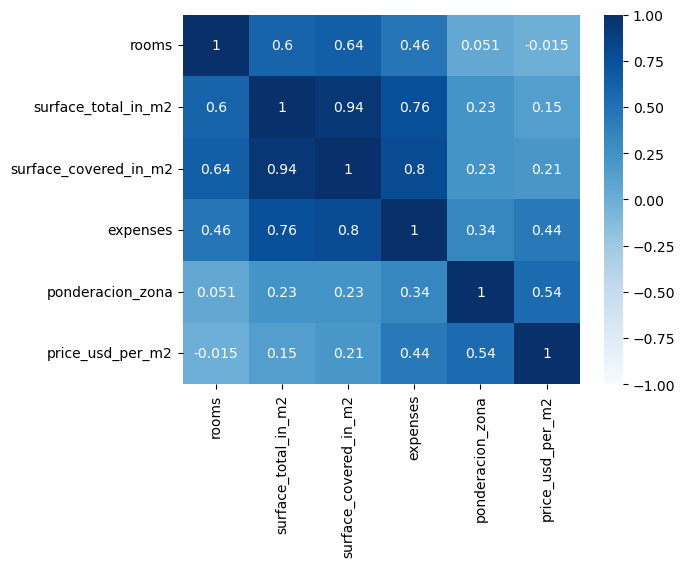

In [11]:
# Visualizo la matriz de correlación entre las variables.
sns.heatmap(mask_corr.corr(), annot=True, vmin=-1, cmap='Blues');

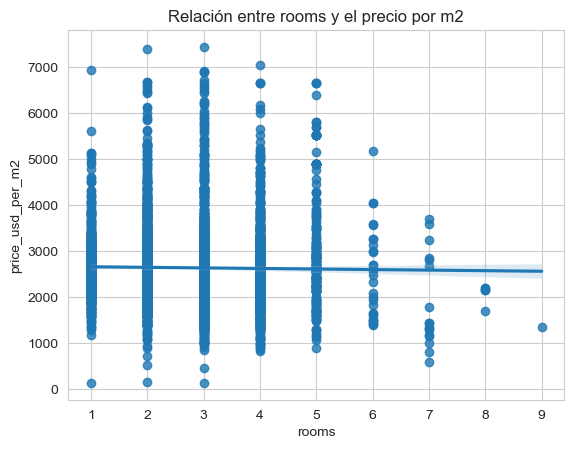

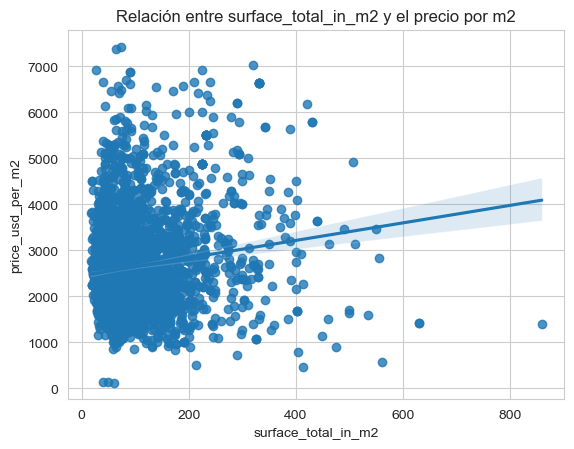

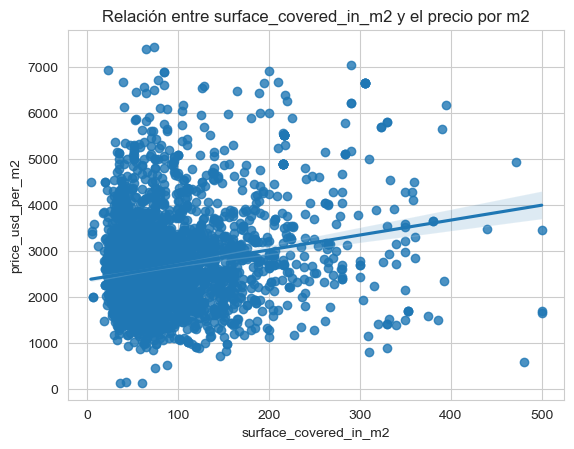

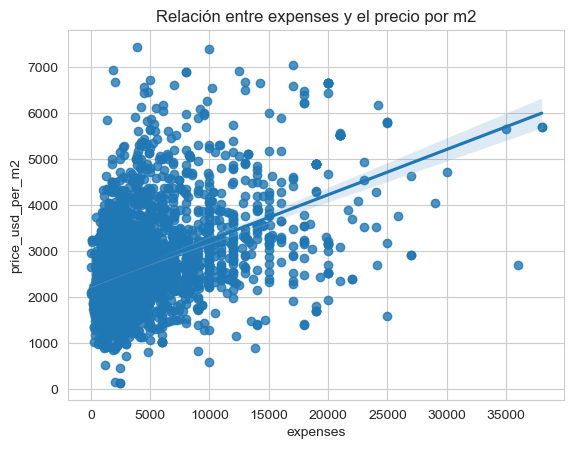

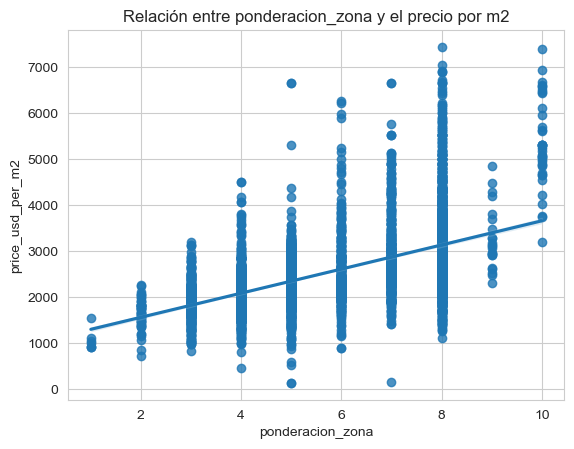

In [12]:
# Creo los gráficos.
for feature in feature_cols:
    # Creo el gráfico.
    sns.set_style("whitegrid")
    sns.regplot(x = data_caba_v2[feature], y = data_caba_v2["price_usd_per_m2"])
    
    # Agrego el título y etiquetas de los ejes.
    plt.title(f"Relación entre {feature} y el precio por m2")
    plt.xlabel(feature)
    plt.ylabel("price_usd_per_m2")
    
    # Muestro el gráfico.
    plt.show()

## Construcción de modelos

In [13]:
# Importo las librerías para machine learning.
from sklearn.linear_model import LinearRegression, Ridge, Lasso, RidgeCV, LassoCV
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler

**Elijo los hiperparámetros del modelo (Clase Linear Regression)**

In [14]:
model = LinearRegression(fit_intercept = True)
model

LinearRegression()

**Preparo los datos en una matriz de features y un vector target**

In [15]:
# Creo X e y.
X = data_caba_v2[feature_cols] # Variables features.
y = data_caba_v2.price_usd_per_m2 # Variable target.

# Corroboro la shape y el tipo de cada una.
print("Shape X:", X.shape)
print("Type X:", type(X))
print("Shape y:", y.shape)
print("Type y:", type(y))

Shape X: (4147, 5)
Type X: <class 'pandas.core.frame.DataFrame'>
Shape y: (4147,)
Type y: <class 'pandas.core.series.Series'>


**Realizo el re-escalado y estandarizado de los valores de las features**

In [16]:
# Creo un objeto StandardScaler.
scaler = StandardScaler()

# Aplico StandardScaler a las variables en X.
X_scaled = scaler.fit_transform(X)

# Imprimo las primeras 5 filas de X_scaled.
print(X_scaled[:5])

[[-0.68289092 -0.59437424 -0.68656282 -0.56596564 -1.11099941]
 [-0.68289092 -0.63692628 -0.6696109  -0.51126773  0.99881836]
 [ 1.05343565 -0.31069391 -0.26276492 -0.33957024 -1.63845386]
 [-0.68289092 -0.89223857 -0.8730339  -0.56032416  0.99881836]
 [-0.68289092 -0.55182219 -0.53399558 -0.63390879  0.47136392]]


**Separo los sets de entrenamiento y de testeo**

In [17]:
Xtrain, Xtest, ytrain, ytest = train_test_split(X_scaled, y, random_state = 1)

**Ajusto el modelo a los datos de entrenamiento**

In [18]:
model.fit(Xtrain, ytrain)

LinearRegression()

In [19]:
model.coef_

array([-128.48068985, -505.47798094,  260.25420642,  492.23943212,
        402.10863336])

In [20]:
model.intercept_

2639.437260732484

**Predigo etiquetas para datos desconocidos**

In [21]:
ypred = model.predict(Xtest)
ypred

array([2977.692719  , 2446.8110438 , 2340.35944224, ..., 3311.77325758,
       3879.08129855, 2093.88862983])

**Evaluo la performance del modelo**

In [22]:
print ('MAE:', mean_absolute_error(ytest, ypred).round(2))
print ('MSE:', mean_squared_error(ytest, ypred).round(2))
print ('RMSE:', np.sqrt(mean_squared_error(ytest, ypred)).round(2))
print ('R2:', r2_score(ytest, ypred).round(2))

MAE: 466.9
MSE: 399047.2
RMSE: 631.7
R2: 0.46


**Ahora con Statsmodels...**

In [23]:
# Importo la api. Uso SM para mirar insights.
import statsmodels.api as sm

# Creo X e y.
X = data_caba_v2[feature_cols] # Variables features.
y = data_caba_v2.price_usd_per_m2 # Variables target.

# Separo los sets de entrenamiento y testeo.
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, random_state = 1)

# Tengo que agregar explícitamente a una constante.
X_train_sm = sm.add_constant(X_train)

# Ajusto el modelo a los datos de entrenamiento.
model = sm.OLS(y_train, X_train_sm).fit()

# Imprimo un resumen del modelo.
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:       price_usd_per_m2   R-squared:                       0.453
Model:                            OLS   Adj. R-squared:                  0.452
Method:                 Least Squares   F-statistic:                     514.0
Date:                Thu, 09 Mar 2023   Prob (F-statistic):               0.00
Time:                        22:25:35   Log-Likelihood:                -24739.
No. Observations:                3110   AIC:                         4.949e+04
Df Residuals:                    3104   BIC:                         4.953e+04
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       2639.4373     12.374    213.305      0.0

**Regularización con Ridge y Lasso -  Cross validation**

In [24]:
# Seteo los folds y el alpha.
folds_range = range(2, 11) # Probamos entre 2 y 10 folds.
alphas = [0.001, 0.01, 0.1, 1, 10, 100, 1000] # Con distintos valores de alpha.

In [25]:
# Defino dos valores vacios numéricos para recorrer en un for para Ridge.
best_score_ridge = -np.inf
best_folds_ridge = None

for folds in folds_range:
    
    model_ridge_cv = RidgeCV(alphas=alphas, cv=folds)
    # Itero sobre distintos valores de fold.
    scores_ridge = cross_val_score(model_ridge_cv, X_train, y_train, cv=folds)
    # Hago un promedio de los valores iterados. 
    mean_score_ridge = scores_ridge.mean()
    # Si el promedio es mayor que el valor más alto alcanzado.
    if mean_score_ridge > best_score_ridge:
        # Entonces el promedio es el valor más alcanzado.
        best_score_ridge = mean_score_ridge
        # Para este número de folds.
        best_folds_ridge = folds

print("Mejor número de folds para Ridge:", best_folds_ridge)
print("Mejor score promedio para Ridge:", best_score_ridge)

Mejor número de folds para Ridge: 2
Mejor score promedio para Ridge: 0.44988958392055955


In [26]:
# Defino dos valores vacios numéricos para recorrer en un for para Lasso.
best_score_lasso = -np.inf
best_folds_lasso = 0

for folds in folds_range:
    
    model_lasso_cv = LassoCV(alphas=alphas, cv=folds)
    # Itero sobre distintos valores de fold.
    scores_lasso = cross_val_score(model_lasso_cv, X_train, y_train, cv=folds)
    # Hago un promedio de los valores iterados.
    mean_score_lasso = scores_lasso.mean()
    # Si el promedio es mayor que el valor más alto alcanzado.
    if mean_score_lasso > best_score_lasso:
        # Entonces el promedio es el valor más alcanzado.
        best_score_lasso = mean_score_lasso
        # Para este número de folds.
        best_folds_lasso = folds

print("Mejor número de folds para Lasso:", best_folds_lasso)
print("Mejor score promedio para Lasso:", best_score_lasso)

Mejor número de folds para Lasso: 2
Mejor score promedio para Lasso: 0.4504863629422801


**Comparación de predicciones y elección de portafolio óptimo**

In [27]:
X_scaled_v2 = sm.add_constant(X_scaled)
ypred = model.predict(X_scaled_v2)
diff=y-ypred
data_caba_v2.loc[:, "diff"] = diff
data_caba_v2.sort_values("diff")
muestra = data_caba_v2.sample(100, random_state=6)
presupuesto = muestra.price_aprox_usd.sum()
print("Presupuesto disponible: ",presupuesto)

venta=data_caba_v2["price_aprox_usd"]
suma = 0
i=0
while suma < presupuesto:
    suma = suma + venta.iloc[i]
    i = i+1

print("Propiedades adquiridas: ", i)
print("Excedente presupuestario: ",round(presupuesto - venta.iloc[0:i-1].sum(),2))

Presupuesto disponible:  21761671.0
Propiedades adquiridas:  101
Excedente presupuestario:  228971.0


C:\Users\maxim\AppData\Local\Temp\ipykernel_12084\2716459056.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_caba_v2.loc[:, "diff"] = diff
